# Обучение моделей

## Общие импорты и функции

Импорты библиотек

In [103]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import ast
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "microsoft/codebert-base"
device

device(type='cuda')

Класс модели

In [87]:
class CodeBERTWithOptionalGraphEmbeddings(nn.Module):
    def __init__(self, base_model, graph_emb_size, dropout_rate=0.1, hidden_size=768):
        super().__init__()
        self.base_model = base_model
        self.graph_emb_size = graph_emb_size
        self.dropout = nn.Dropout(dropout_rate)  # Dropout слой для предотвращения переобучения
        self.fc = nn.Linear(hidden_size + graph_emb_size, 1)  # Линейный слой для предсказания
        
        # Замораживаем все слои base_model, кроме слоя эмбеддингов и последнего слоя
        for param in self.base_model.parameters():
            param.requires_grad = False
        # Размораживаем слой эмбеддингов
        for param in self.base_model.embeddings.parameters():
            param.requires_grad = True
        # Размораживаем последний слой
        for param in self.base_model.encoder.layer[-1].parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask, graph_embeddings=None):
        # Извлекаем эмбеддинги текста через CodeBERT
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = outputs.last_hidden_state  # shape: [batch_size, seq_len, hidden_size]

        # Берём CLS токен
        cls_emb = text_embeddings[:, 0, :]  # shape [batch_size, hidden_size]
        
        # Конкатенируем с graph_embeddings по признаковому измерению
        if graph_embeddings is not None and graph_embeddings.size(0) > 0:
            cls_emb = torch.cat([cls_emb, graph_embeddings], dim=-1)
        cls_emb = self.dropout(cls_emb)  # Применяем Dropout
        output = self.fc(cls_emb)

        return output

Класс датасета

In [109]:
# == Датасет ==
class SODataset(Dataset):
    def __init__(self, texts, targets, tokenizer, graph_embeddings=None, max_len=512):
        self.targets = torch.tensor(targets, dtype=torch.float)
        if graph_embeddings is not None:
            self.graph_embeddings = torch.tensor(graph_embeddings, dtype=torch.float)
        else:
            self.graph_embeddings = None

        # Пошагово токенизируем с прогрессом
        all_input_ids = []
        all_attention_masks = []
        for text in tqdm(texts, desc="Tokenizing texts"):
            enc = tokenizer(
                text,
                padding='max_length',
                truncation=True,
                max_length=max_len,
                return_tensors='pt'
            )
            all_input_ids.append(enc['input_ids'].squeeze(0))
            all_attention_masks.append(enc['attention_mask'].squeeze(0))

        self.input_ids = torch.stack(all_input_ids)
        self.attention_mask = torch.stack(all_attention_masks)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        # Получаем графовый эмбеддинг для текущей строки
        if self.graph_embeddings is not None:
            graph_emb = self.graph_embeddings[idx]
        else:
            graph_emb = torch.zeros(1, dtype=torch.float)

        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'target': self.targets[idx],
            'graph_embeddings': graph_emb
        }


Функция для обучения модели

In [94]:
# === Функция обучения ===
def train_model(model, train_loader, val_loader, name='text embeddings', num_epochs=3, lr=1e-5, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    # Инициализация TensorBoard
    log_dir = f'./logs/{name}_{datetime.now().strftime("%m_%d_%H_%M")}'
    print("Saved in", log_dir)
    writer = SummaryWriter(log_dir=log_dir)

    # Списки для хранения потерь
    train_losses = []  
    val_losses = []    
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for step, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['target'].to(device)
            if name != 'text embeddings':
                graph_embeddings = batch['graph_embeddings'].to(device)
                preds = model(input_ids, attention_mask, graph_embeddings)
            else:
                preds = model(input_ids, attention_mask)
            loss = criterion(preds.squeeze(), target)  # Сравниваем с таргетом
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            writer.add_scalar('Loss/train_step', loss.item(), global_step=epoch * len(train_loader) + step)

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Валидация
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                target = batch['target'].to(device)
                if name != 'text embeddings':
                    graph_embeddings = batch['graph_embeddings'].to(device)
                    preds = model(input_ids, attention_mask, graph_embeddings)
                else:
                    preds = model(input_ids, attention_mask)
                val_loss += criterion(preds.squeeze(), target).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Логируем потери на валидации и трайне в TensorBoard
        writer.add_scalar('Loss/train_epoch', avg_train_loss, epoch)
        writer.add_scalar('Loss/val_epoch', avg_val_loss, epoch)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        clear_output(wait=True)

        # Потери на тренировке и валидации
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epoch+2), train_losses, label="Train Loss")
        plt.plot(range(1, epoch+2), val_losses, label="Validation Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        name_split = ' '.join(name.split('_'))
        plt.title(f'Loss Curve of Model  with {name_split}')
        plt.legend()
        plt.show()

        # Сохраняем модель на каждой эпохе
        filename = '_'.join(name.split())
        torch.save(model.state_dict(), f"models/{filename}_{epoch}.pt")

    # Закрываем writer
    writer.close()

Функция для скачивания эмбеддингов и их соотнесения с датасетом постов.

In [95]:
def embedding_column(df: pd.DataFrame,
                         pkl_path: str,
                         tags_column='tags_filtered') -> pd.DataFrame:
    """
    Загружает эмбеддинги тегов из pkl файла и добавляет в датафрейм новую колонку с усреднённым эмбеддингом по тегам.

    Parameters:
        df (pd.DataFrame): датафрейм с колонкой тегов.
        pkl_path (str): путь к файлу .pkl с эмбеддингами тегов.
        tags_column (str): название колонки с тегами (типа list или строка с разделителем).

    Returns:
        pd.DataFrame: датафрейм с добавленным столбцом new_column.
    """
    # Загрузим словарь тегов
    with open(pkl_path, 'rb') as f:
        emb_dict = pickle.load(f)

    # Функция для усреднения эмбеддингов тегов
    def average_embeddings(tags):
        # приводим к списку, если это строка
        if isinstance(tags, str):
            tags = ast.literal_eval(tags)
        embs = [emb_dict[tag] for tag in tags]
        return np.expand_dims(np.mean(embs, axis=0), 0)

    return np.concatenate([average_embeddings(tags) for tags in df[tags_column]], axis=0)

Функции для скачивания данных и получения модели

In [96]:
def load_data(embedding_path=None):
    # === Основной код подготовки ===
    df = pd.read_csv('so_questions.csv')
    df['target'] = df['score'] / np.log1p(df['view_count'])
    df['text_with_tags'] = df.apply(
        lambda row: f"tags: {row['tags_filtered']}\n{row['full_text']}",
        axis=1
    )
    
    # Загружаем графовые эмбеддинги (если они есть)
    graph_embeddings = None
    if embedding_path is not None:
        graph_embeddings = embedding_column(df, f'embeddings/{embedding_path}.pkl')
    
    # Токенизатор и модель
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    special_tokens = ["[CODE_START]", "[CODE_END]", "[INLINE_CODE_START]", "[INLINE_CODE_END]"]
    tokenizer.add_tokens(special_tokens)
    
    # Разделение выборки
    if embedding_path is None:
        emb_train, emb_test = None, None
        len_emb = 0
        X_train, X_test, y_train, y_test = train_test_split(
            df['text_with_tags'].tolist(),
            df['target'].values,
            test_size=0.2,
            random_state=42
        )
    else:
        len_emb = graph_embeddings.shape[1]
        X_train, X_test, y_train, y_test, emb_train, emb_test = train_test_split(
            df['text_with_tags'].tolist(),
            df['target'].values,
            graph_embeddings,
            test_size=0.2,
            random_state=42
        )
        
    train_data = SODataset(X_train, y_train, tokenizer, graph_embeddings=emb_train)
    val_data = SODataset(X_test, y_test, tokenizer, graph_embeddings=emb_test)
    
    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=8)

    print("Use embeggings of size", len_emb)
    return train_loader, val_loader, tokenizer, len_emb

def get_model(tokenizer, len_emb):
    base_model = RobertaModel.from_pretrained(model_name)
    base_model.resize_token_embeddings(len(tokenizer))  
    model = CodeBERTWithOptionalGraphEmbeddings(base_model, graph_emb_size=len_emb)
    return model

## Обучение моделей

Базовая модель без графовых эмбеддингов

In [ ]:
train_loader, val_loader, tokenizer, len_emb = load_data()

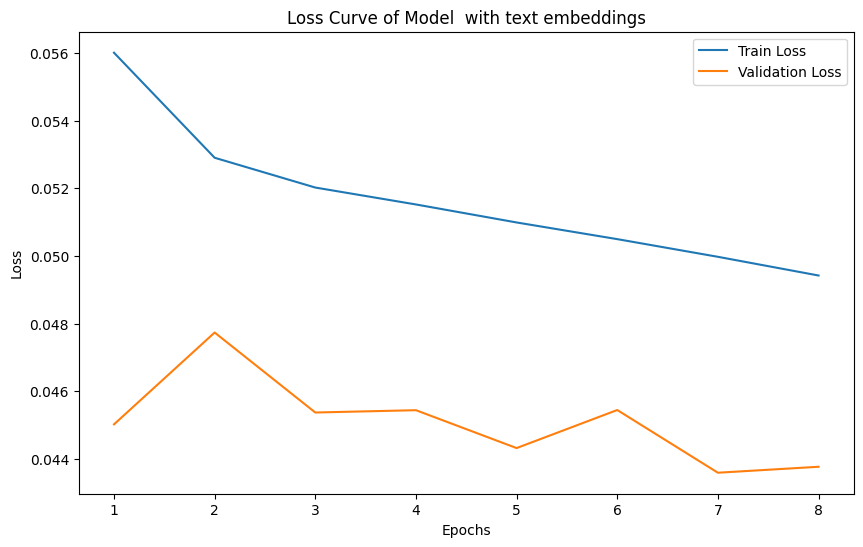

Модель обучена и сохранена


In [15]:
model = get_model(tokenizer, len_emb)

# === Обучение модели ===
train_model(model, train_loader, val_loader, name='text embeddings', num_epochs=8, lr=1e-5, device=device)
print("Модель обучена и сохранена")

Модель с эмбеддингами центральностей

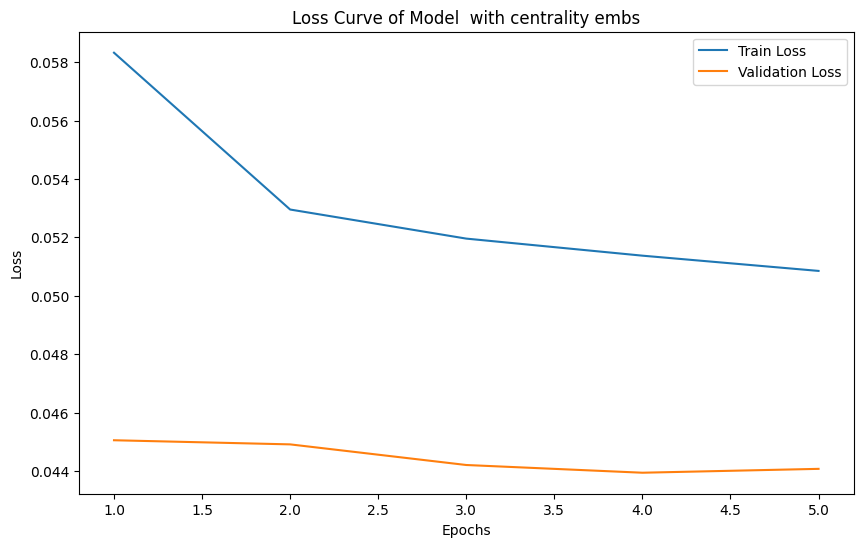

In [97]:
name = 'centrality_embs'
train_loader, val_loader, tokenizer, len_emb = load_data(name)
model = get_model(tokenizer, len_emb)
train_model(model, train_loader, val_loader, name=name, num_epochs=5, lr=1e-5, device=device)

Модель с эмбеддингами  GAT + GAE.

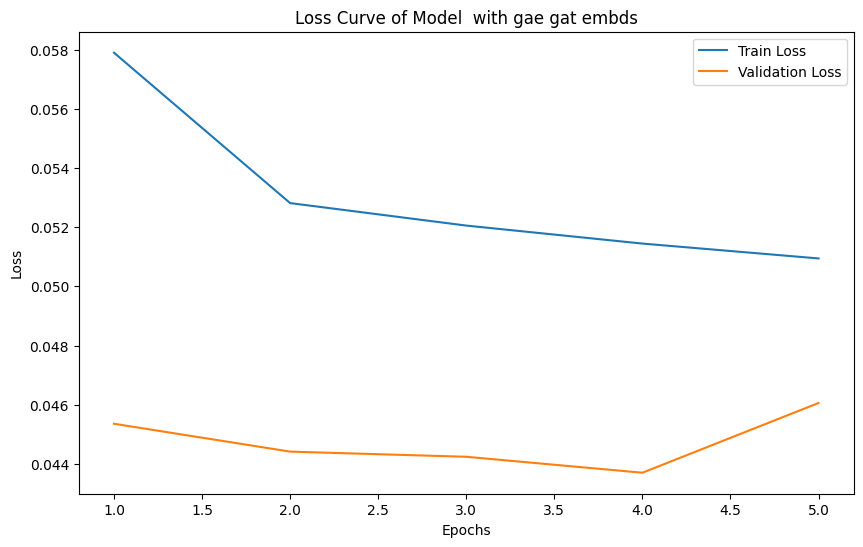

In [98]:
name = 'gae_gat_embds'
train_loader, val_loader, tokenizer, len_emb = load_data(name)
model = get_model(tokenizer, len_emb)
train_model(model, train_loader, val_loader, name=name, num_epochs=5, lr=1e-5, device=device)

Модель с эмбеддингами из SVD разложения матрицы смежности.

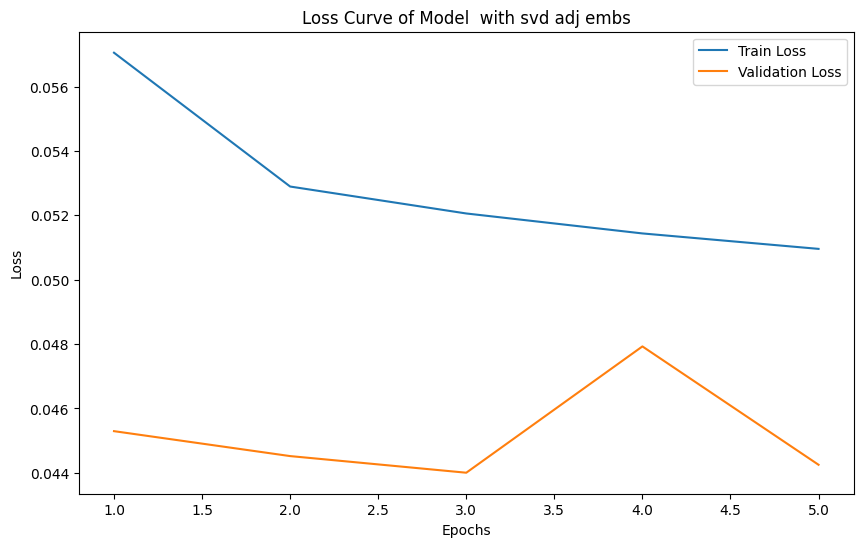

In [99]:
name = 'svd_adj_embs'
train_loader, val_loader, tokenizer, len_emb = load_data(name)
model = get_model(tokenizer, len_emb)
train_model(model, train_loader, val_loader, name=name, num_epochs=5, lr=1e-5, device=device)

Модель с эмбеддингами GCN + VGAE.

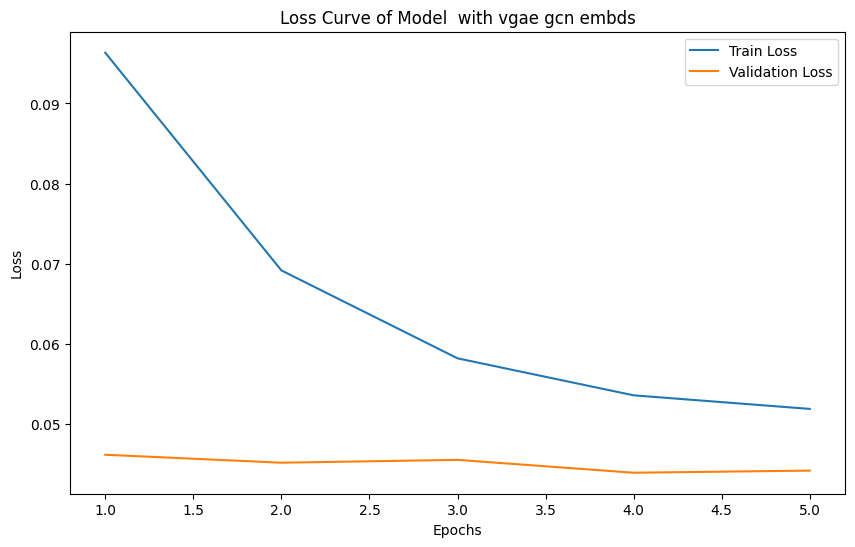

In [100]:
name = 'vgae_gcn_embds'
train_loader, val_loader, tokenizer, len_emb = load_data(name)
model = get_model(tokenizer, len_emb)
train_model(model, train_loader, val_loader, name=name, num_epochs=5, lr=1e-5, device=device)

Модель с эмбеддингами GCN + GAE.

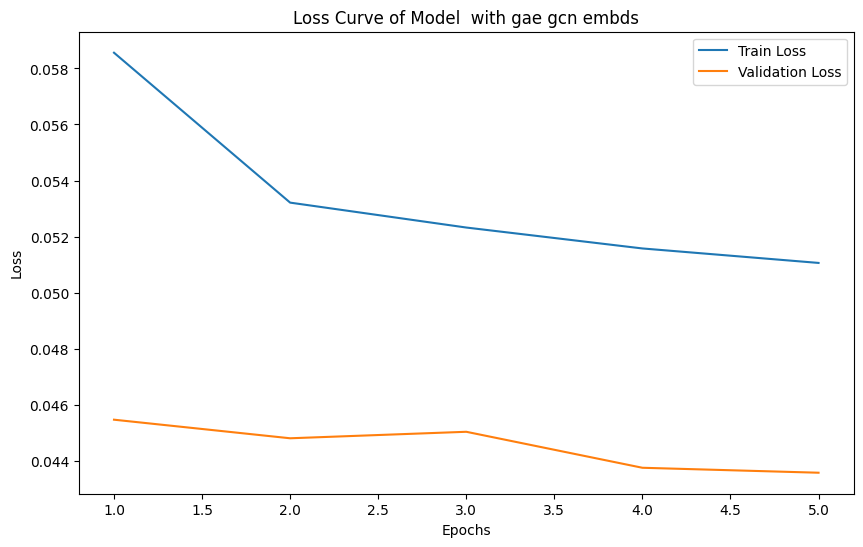

In [101]:
name = 'gae_gcn_embds'
train_loader, val_loader, tokenizer, len_emb = load_data(name)
model = get_model(tokenizer, len_emb)
train_model(model, train_loader, val_loader, name=name, num_epochs=5, lr=1e-5, device=device)

Модель с эмбеддингами из SVD разложения нормализованного лапласиана.

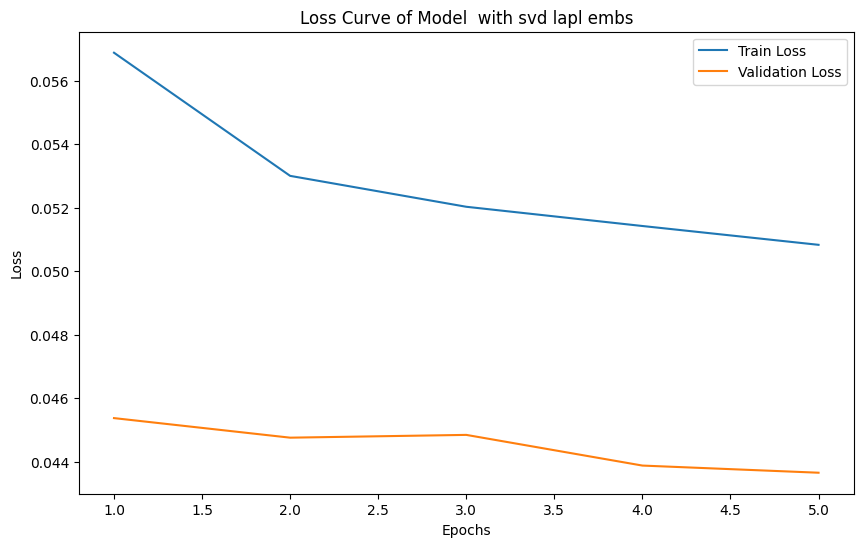

In [102]:
name = 'svd_lapl_embs'
train_loader, val_loader, tokenizer, len_emb = load_data(name)
model = get_model(tokenizer, len_emb)
train_model(model, train_loader, val_loader, name=name, num_epochs=5, lr=1e-5, device=device)

## Валидация

Функции для скачавания данных для валидации.

In [111]:
def load_eval(embedding_path=None):
    # === Основной код подготовки ===
    df = pd.read_csv('so_questions.csv')
    df['target'] = df['score'] / np.log1p(df['view_count'])
    df['text_with_tags'] = df.apply(
        lambda row: f"tags: {row['tags_filtered']}\n{row['full_text']}",
        axis=1
    )
    
    # Загружаем графовые эмбеддинги (если они есть)
    graph_embeddings = None
    if embedding_path is not None:
        graph_embeddings = embedding_column(df, f'embeddings/{embedding_path}.pkl')
    
    # Токенизатор и модель
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    special_tokens = ["[CODE_START]", "[CODE_END]", "[INLINE_CODE_START]", "[INLINE_CODE_END]"]
    tokenizer.add_tokens(special_tokens)
    
    # Разделение выборки
    if embedding_path is None:
        emb_train, emb_test = None, None
        len_emb = 0
        X_train, X_test, y_train, y_test = train_test_split(
            df['text_with_tags'].tolist(),
            df['target'].values,
            test_size=0.2,
            random_state=42
        )
    else:
        len_emb = graph_embeddings.shape[1]
        X_train, X_test, y_train, y_test, emb_train, emb_test = train_test_split(
            df['text_with_tags'].tolist(),
            df['target'].values,
            graph_embeddings,
            test_size=0.2,
            random_state=42
        )
        
    val_data = SODataset(X_test, y_test, tokenizer, graph_embeddings=emb_test)
    
    val_loader = DataLoader(val_data, batch_size=8)

    print("Use embeggings of size", len_emb)
    
    base_model = RobertaModel.from_pretrained(model_name)
    base_model.resize_token_embeddings(len(tokenizer))  
    model = CodeBERTWithOptionalGraphEmbeddings(base_model, graph_emb_size=len_emb)
    filename = embedding_path if embedding_path is not None else 'text_embedding'
    model.load_state_dict(torch.load(f'models/{filename}_4.pt'))
    
    return val_loader, tokenizer, model

Функция для валидации и отображения графиков.

In [114]:
# === Функция для вычисления метрик и визуализации ===
def evaluate_model(model, data_loader, device, name='text_embedding'):
    model.eval()  # Переводим модель в режим оценки
    model.to(device)
    all_preds = []
    all_targets = []
    
    # Прогоняем модель по всем данным и собираем предсказания и таргеты
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['target'].to(device)
            if name != 'text_embedding':
                graph_embeddings = batch['graph_embeddings'].to(device)
                preds = model(input_ids, attention_mask, graph_embeddings)
            else:
                preds = model(input_ids, attention_mask)
            all_preds.extend(preds.squeeze().cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Рассчитываем 
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    # Создаем фигуру с двумя горизонтальными графиками
    plt.figure(figsize=(20, 6))
    name_split = " ".join(name.split("_"))
    plt.suptitle(f'Model with {name_split}', fontsize=16, y=1.05)  
    
    # Первый график - Предсказания vs Истинные значения
    plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1 позиция
    plt.scatter(all_targets, all_preds)
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color='red', linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted')
    
    # Второй график - Распределение ошибок
    plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2 позиция
    errors = [t - p for t, p in zip(all_targets, all_preds)]
    plt.hist(errors, bins=50, color='blue', alpha=0.7)
    plt.xlabel('Prediction Errors')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    
    plt.tight_layout()  # Чтобы графики не перекрывались
    plt.show()
    
    return mse, mae, r2

Валидация на всех вариантах эмбеддингов

Tokenizing texts: 100%|█████████████████████████████████| 23964/23964 [01:09<00:00, 343.58it/s]


Use embeggings of size 0
Use model with  text_embedding


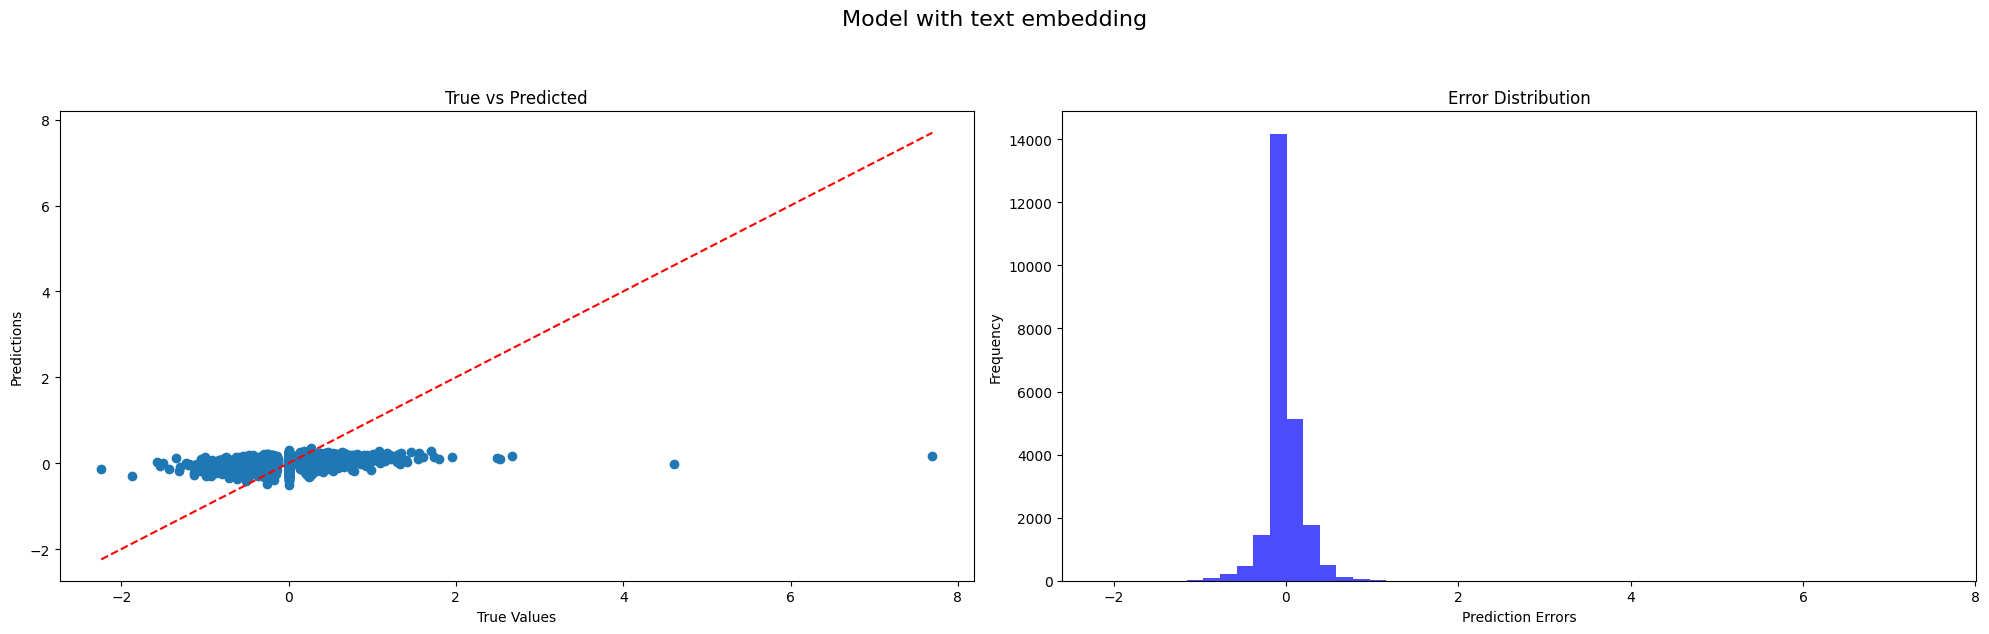

Tokenizing texts: 100%|█████████████████████████████████| 23964/23964 [01:09<00:00, 342.55it/s]


Use embeggings of size 4
Use model with  centrality_embs


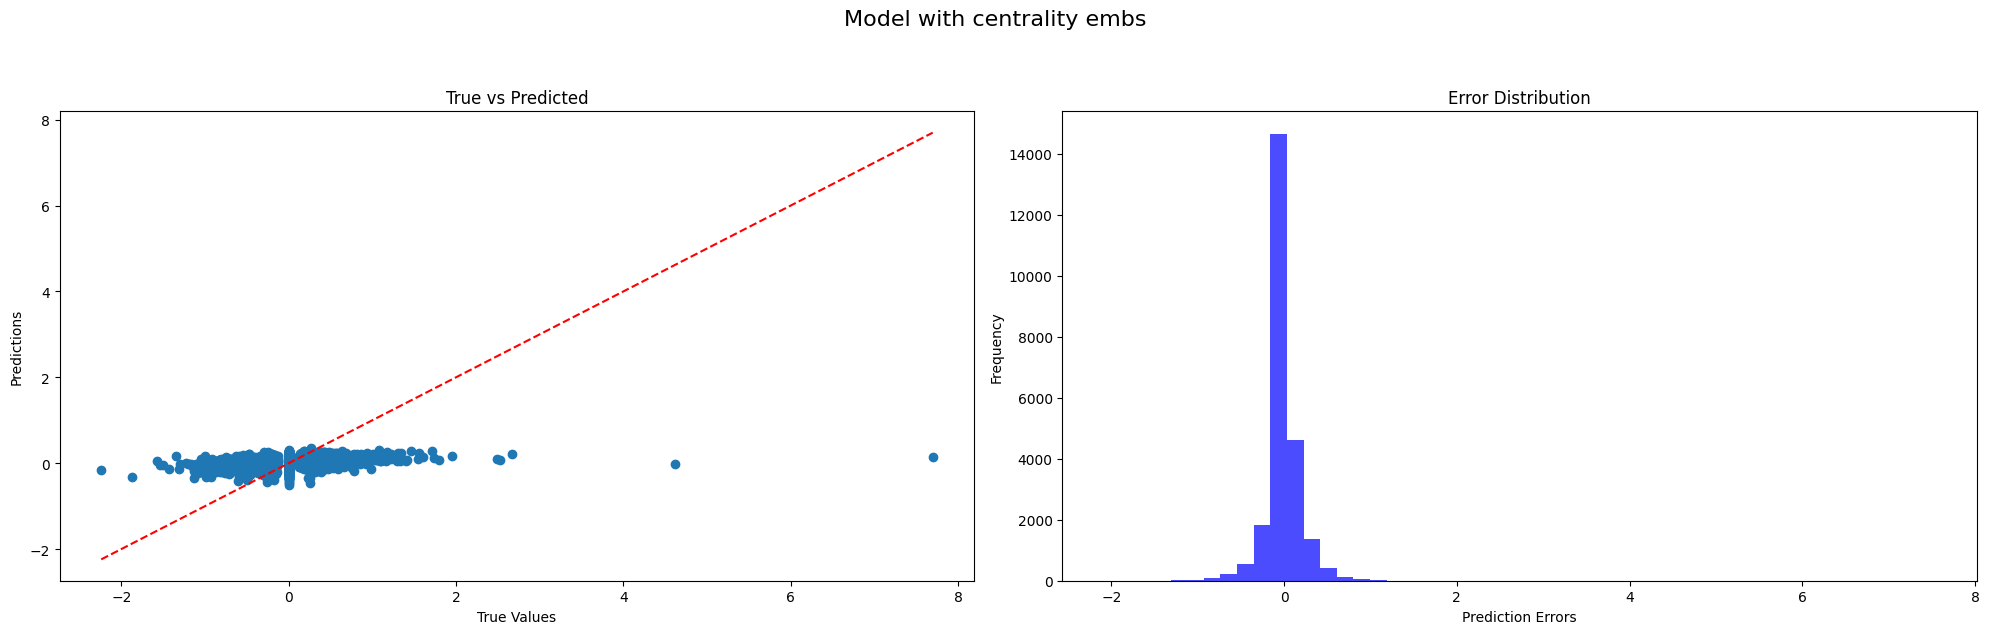

Tokenizing texts: 100%|█████████████████████████████████| 23964/23964 [01:09<00:00, 343.43it/s]


Use embeggings of size 64
Use model with  gae_gat_embds


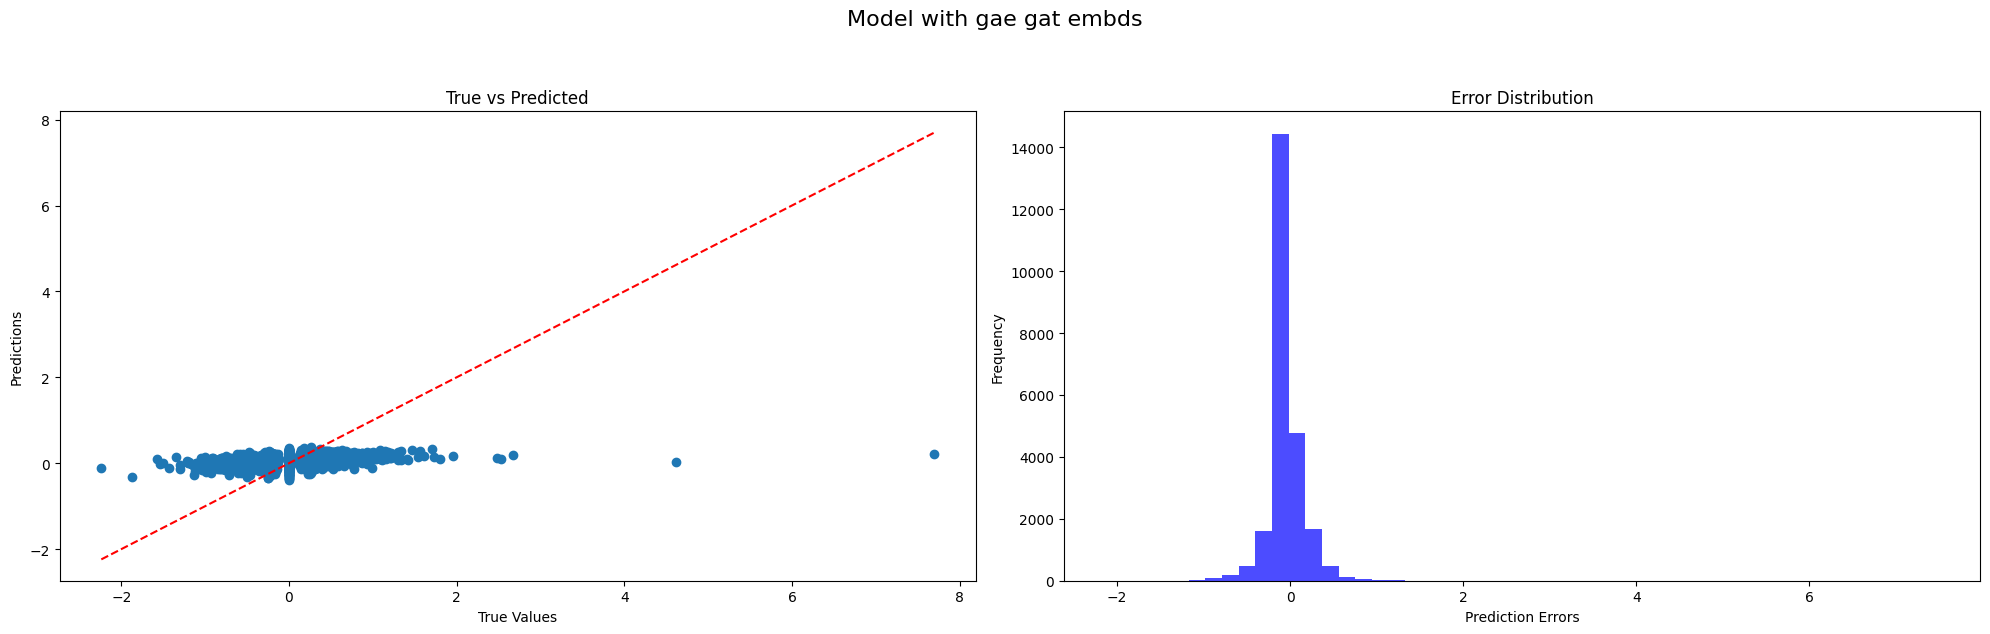

Tokenizing texts: 100%|█████████████████████████████████| 23964/23964 [01:10<00:00, 340.05it/s]


Use embeggings of size 64
Use model with  svd_adj_embs


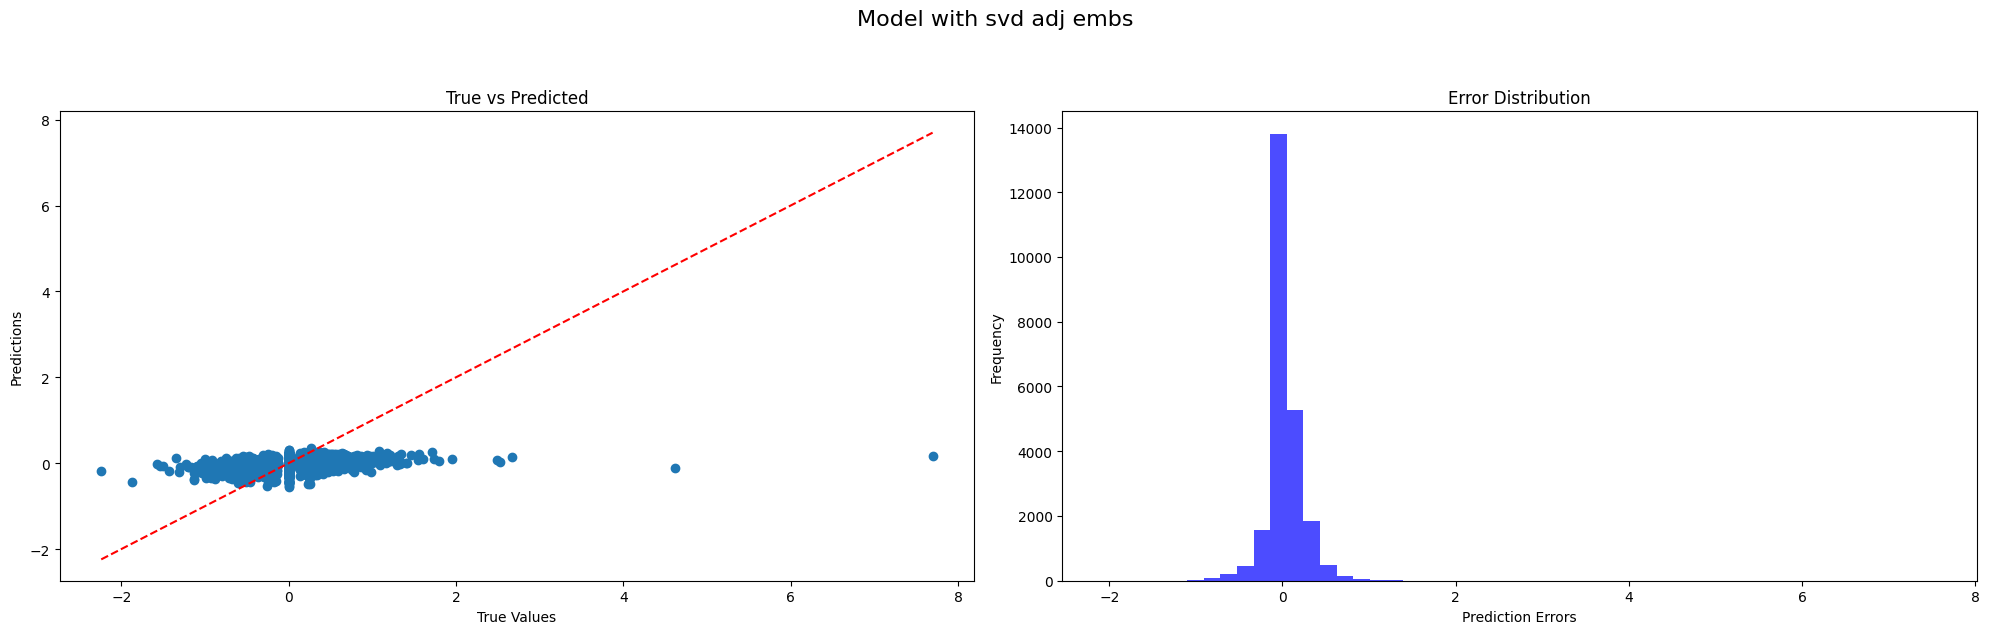

Tokenizing texts: 100%|█████████████████████████████████| 23964/23964 [01:09<00:00, 343.39it/s]


Use embeggings of size 128
Use model with  vgae_gcn_embds


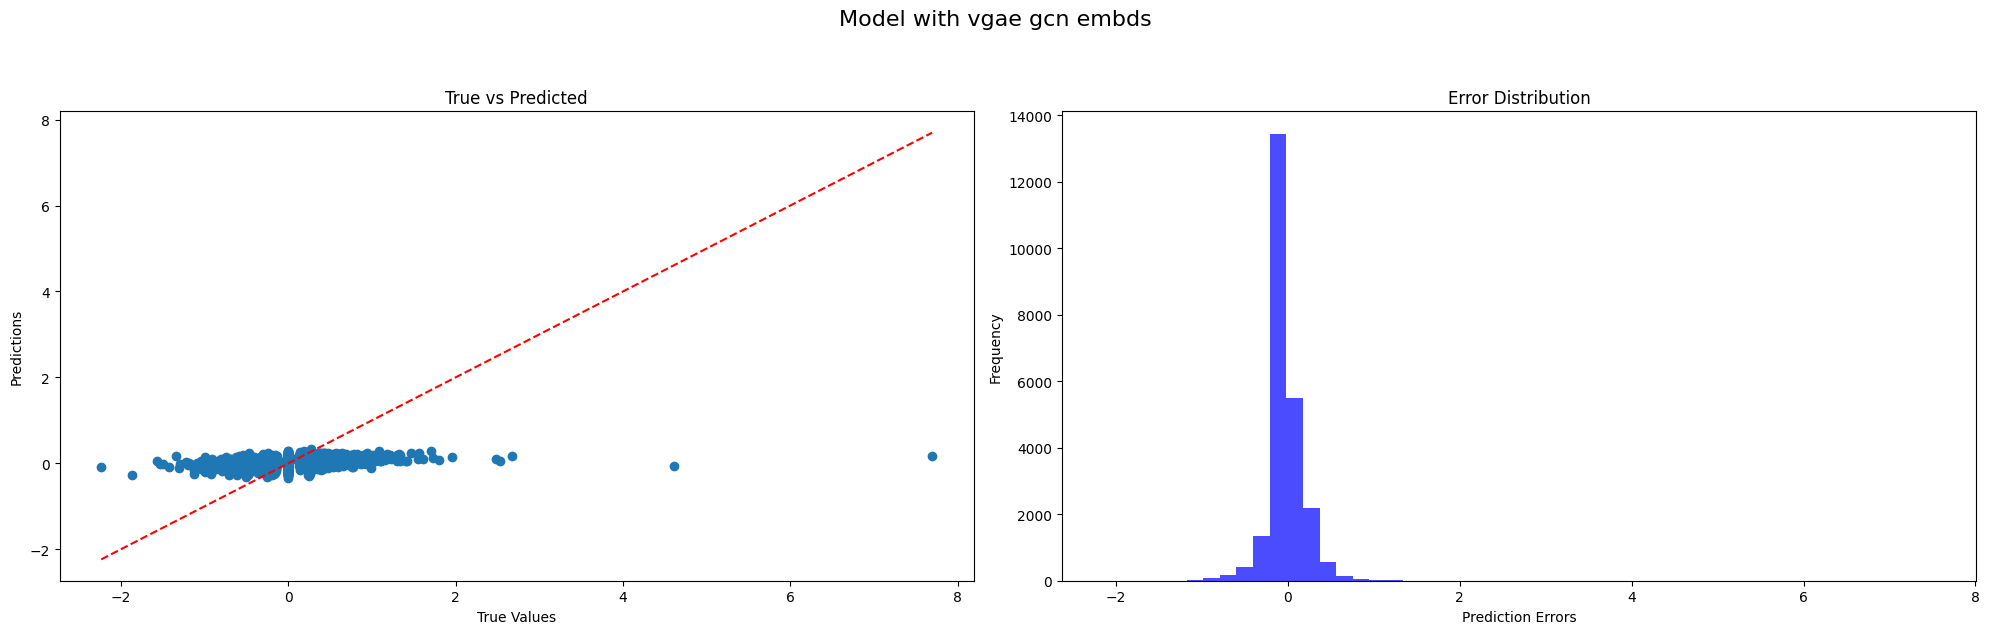

Tokenizing texts: 100%|█████████████████████████████████| 23964/23964 [01:10<00:00, 339.75it/s]


Use embeggings of size 64
Use model with  gae_gcn_embds


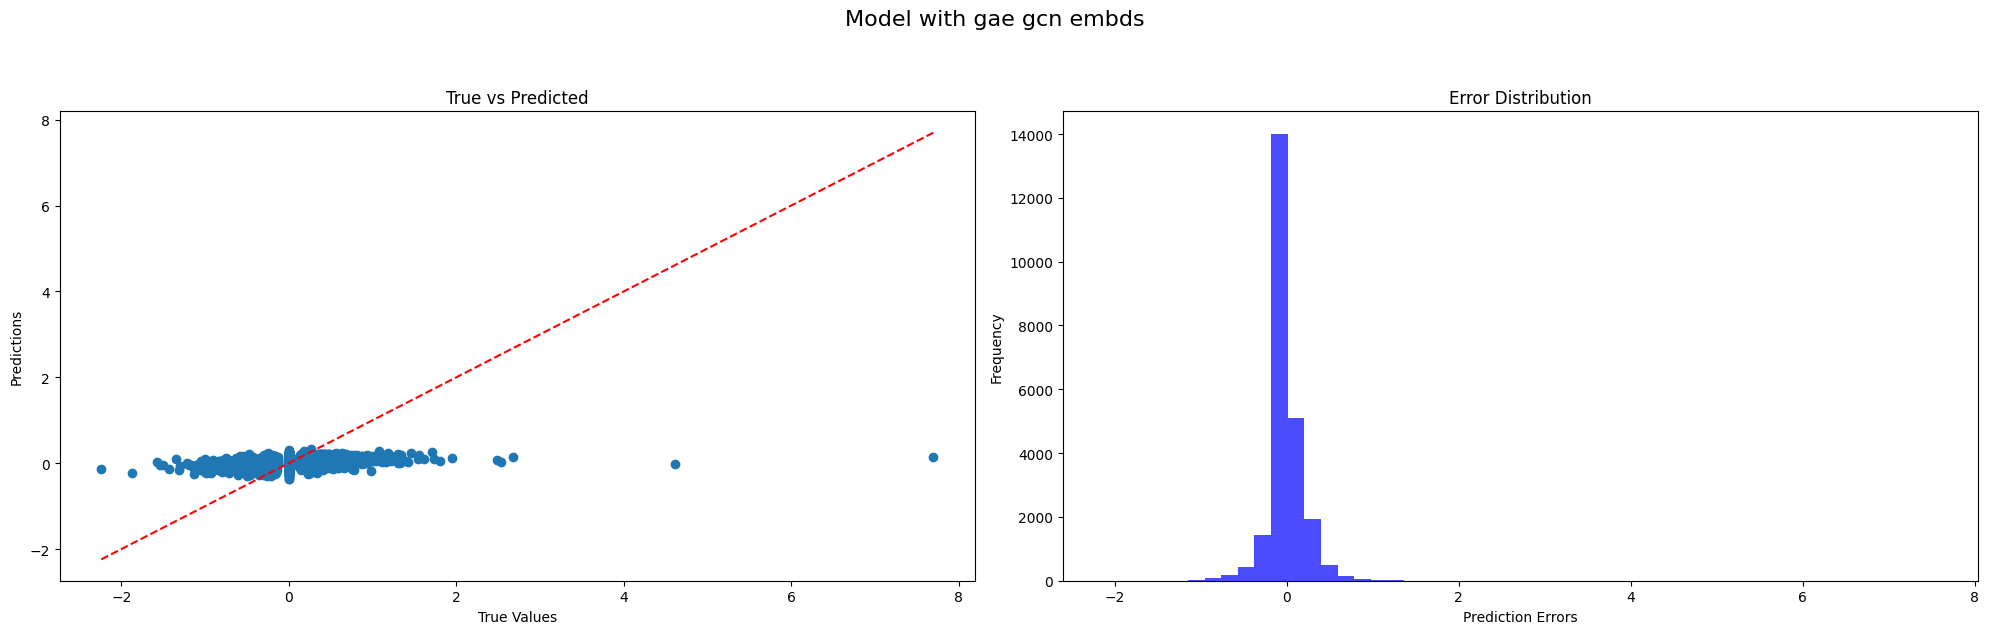

Tokenizing texts: 100%|█████████████████████████████████| 23964/23964 [01:09<00:00, 342.84it/s]


Use embeggings of size 64
Use model with  svd_lapl_embs


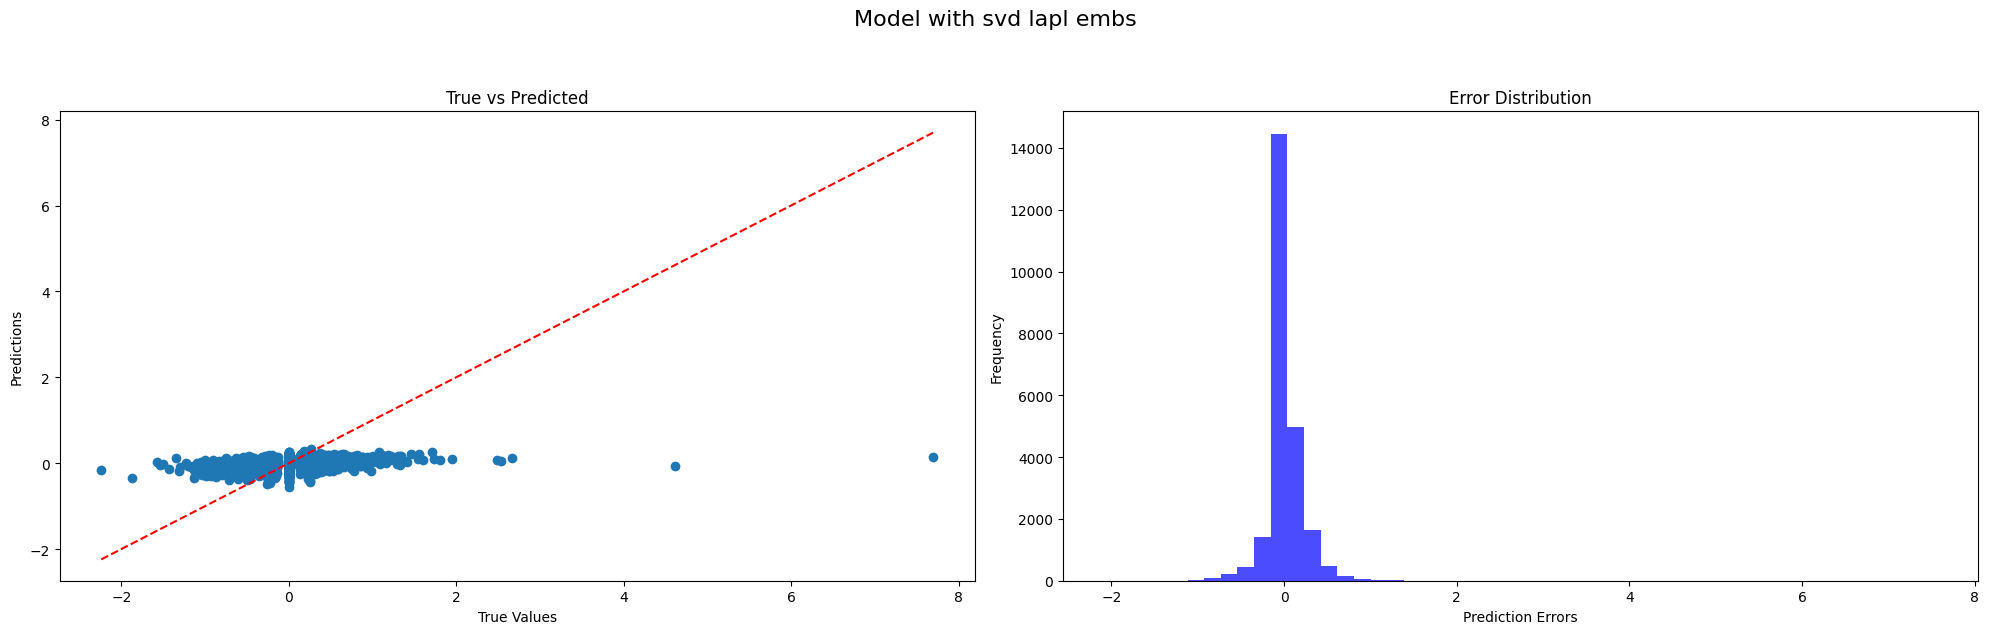

,model_name,MSE,MAE,R2
0,text_embedding,0.044319,0.140426,0.063100
1,centrality_embs,0.044072,0.138143,0.068313
2,gae_gat_embds,0.046059,0.148388,0.026313
3,svd_adj_embs,0.044253,0.129838,0.064493
4,vgae_gcn_embds,0.044128,0.137223,0.067145
5,gae_gcn_embds,0.043579,0.130878,0.078746
6,svd_lapl_embs,0.043657,0.133212,0.077095


In [117]:
result = pd.DataFrame(columns=['model_name', 'MSE', 'MAE', 'R2'])

for embegging_path in [None, 'centrality_embs', 'gae_gat_embds', 'svd_adj_embs', 'vgae_gcn_embds', 
                       'gae_gcn_embds', 'svd_lapl_embs']:
    val_loader, tokenizer, model = load_eval(embedding_path=embegging_path)
    name = embegging_path
    if name is None:
        name = 'text_embedding'
    print("Use model with ", name)
    mse, mae, r2 = evaluate_model(model, val_loader, device, name)
    new_row = {'model_name': name, 'MSE': mse, 'MAE': mae, 'R2': r2}
    result.loc[len(result)] = new_row
    
result